# Introduction

### Problem Description

In this presentation, performance of LSTM (Long Short-Term Memory neural network) in a specific task is compared with that of MLP (Multi-Layer Perceptron). However, MLP is trained on a data matrix where features are derived based on varying number of previous steps. Such feature engineering mimics ability to remember past information for an arbitrary number of time steps.  

Generally speaking, the task under consideration is forecasting with horizon that is bigger than one step. In other words, models are trained to predict future values several steps ahead simultaneously, without passing predictions for previous future steps as ground truth. It is assumed that models should be trained to recognize temporal patterns in a sequence of observations, and prediction of future values based on external variables is beyond the scope of the presentation.

Time series that are used here is a real-world series with hourly frequency and strong intraday seasonality. Because aim of the presentation is to compare performance that is due to sequence modelling aspects of forecasting, nature of the series is not relevant here. Of course, involvement of domain-related features and appropriate external data can result in better accuracy of forecasting.

### Software Requirements

Besides packages that are quite popular in scientific computing, this notebook requires `tensorflow` of version 1.0 or newer. Please look at the [official installation guide](https://www.tensorflow.org/install/) if you need to install or update it.

# General Preparations

### Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  # Imported just in order to make graphs prettier.

from sklearn.metrics import r2_score

import tensorflow as tf

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_seasonality.csv')['value']
ser.head()

0    1.7024
1    0.3600
2    0.0000
3    0.0000
4    0.2848
Name: value, dtype: float64

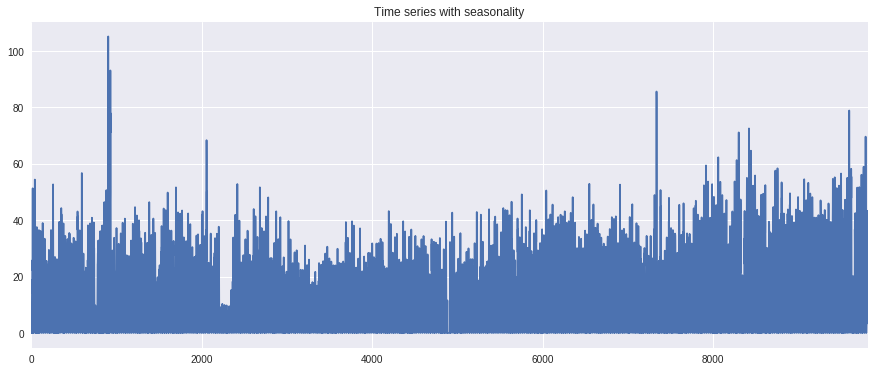

In [3]:
_ = ser.plot(figsize=(15, 6), title='Time series with seasonality')

It is hard to study the series behavior from the above graph, so look at a small pieces of it.

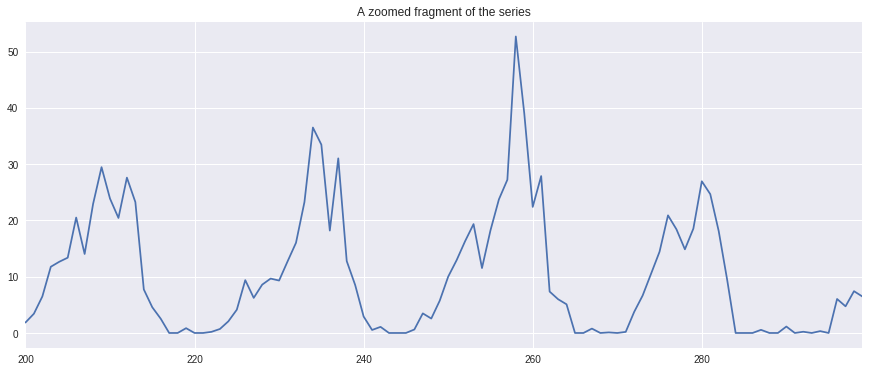

In [4]:
_ = ser[200:300].plot(figsize=(15, 6), title='A zoomed fragment of the series')

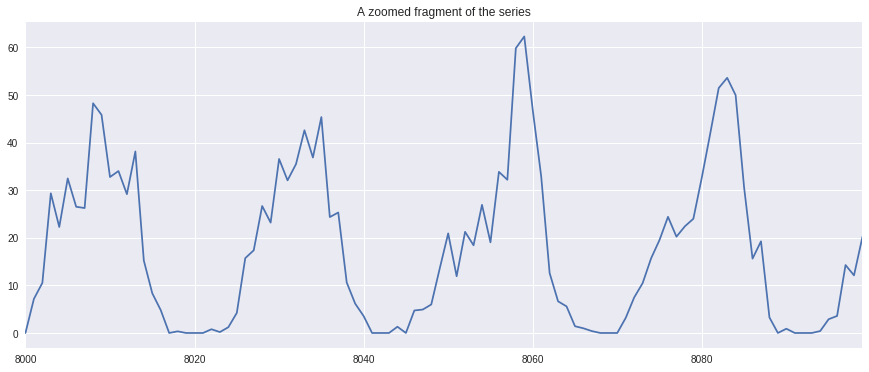

In [5]:
_ = ser[8000:8100].plot(figsize=(15, 6), title='A zoomed fragment of the series')

In [6]:
ser.describe()

count    9817.000000
mean       12.375714
std        12.806379
min         0.000000
25%         0.860800
50%         9.028800
75%        20.532800
max       105.168000
Name: value, dtype: float64

### Baseline model

What forecast quality can be achieved by a simple baseline model such as, say, moving average of a specific window size?

Below MA(24) model is chosen, because 24 is period of seasonality of the series. One can try to use other window sizes — the higher they are, the more slowly predictions made for a long horizon converge to a constant.

In [7]:
window_size = 24
horizon = 100

Split data to a "train" set (actually, moving average has no fitting) and a hold-out test set. 

In [8]:
train_ratio = 0.75
train_test_frontier = int(round(train_ratio * len(ser.index), 0))

-0.10188688141676283

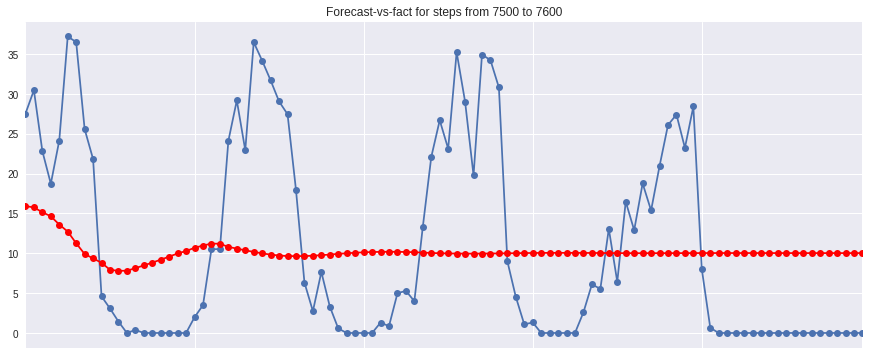

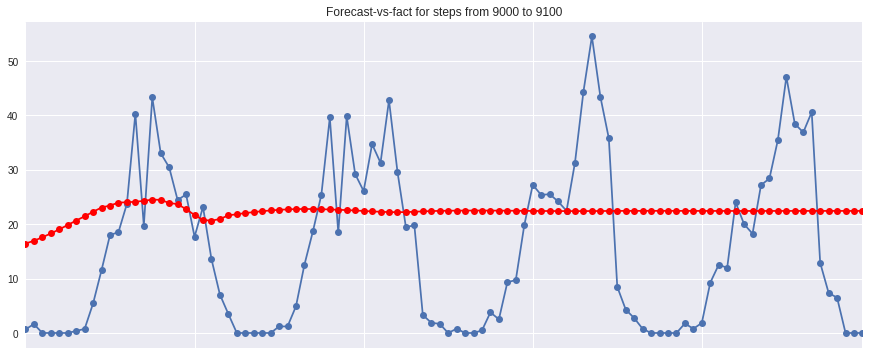

In [9]:
scores = []
for i in range(train_test_frontier, len(ser.index) - horizon):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - window_size):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-window_size:]) / window_size)

    y_hat = y_hat[window_size:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % 1500 == 0:
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
        ax.set_xticklabels([])
        
        y_true.plot(ax=ax, marker='o')
        pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

sum(scores) / len(scores)

Of course, negative value of $R^2$ score is not a bug. As it can be seen, MA(24) predictions converge quite rapidly to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

# Template of Forecasting

In [10]:
def take_ahead_and_lagged_values(ser, horizon, n_lags):
    """
    Converts `ser` to a data matrix
    with `horizon` ahead values and
    `n_lags` lagged values as well
    as a column for current value.
    
    @type ser: pandas.Series
    @type horizon: int
    @type n_lags: int
    @rtype: pandas.DataFrame
    """
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    return df

In [11]:
class AbstractRunner(object):
    """
    Combines and structurizes all utilities
    that evaluate neural networks' performances
    in the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features
    (also other features may be involved).
    """
    
    def __init__(self, horizon, n_lags):
        """
        @type horizon: int
        @type n_lags: int
        """
        self.horizon = horizon
        self.n_lags = n_lags
        
        self.sess = None
        
        self.graph = tf.Graph()
        self._define_placeholders()
            
    def _define_placeholders(self):
        """
        A virtual method.
        
        @rtype: NoneType
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")
        
    def _set_optimization_problem(self):
        """
        Defines optimization problem for training.
        This method must be called by `__init__` of
        child classes after neural network is built.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients in order to improve convergence.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
                                for grad, var in gradients]
            self.train_optim = optimizer.apply_gradients(capped_gradients)
            
    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        A virtual method.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")

    def _test(self, test_ser):
        """
        A virtual method.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")
        
    def _plot(self, true_series, forecasted_series, batch_cnt):
        """
        Visualizes `forecasted_series` against
        `true_series` for a time interval that
        corresponds to `batch_cnt`.
        
        @type true_series: numpy.ndarray
        @type forecasted_series: numpy.ndarray
        @type batch_cnt: int
        @rtype: NoneType
        """
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        start_step = train_test_frontier + batch_cnt  # TODO: capitalize `train_test_frontier`?
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(
            start_step, start_step + self.horizon))
        ax.set_xticklabels([])

        pd.Series(true_series).plot(ax=ax, marker='o')
        pd.Series(forecasted_series).plot(ax=ax, c='red', marker='o')
        
    def run(self, train_ser, test_ser, batch_size, n_epochs, learn_rate, keep_prob,
            ckpt_path=None):
        """
        Trains a model with a specified
        hyperparameters on `train_ser` and
        then evaluates its performance on
        `test_ser`.
        If `ckpt_path` is passed, the trained
        model is serialized as checkpoint
        files.
        
        @type train_ser: pandas.Series
        @type test_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: float
        """
        with tf.Session(graph=self.graph) as self.sess:
            self.sess.run(tf.global_variables_initializer())
            self._train(train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path)
            score = self._test(test_ser)
        return score

# Forecasting with LSTM

### Functions and Classes

In [12]:
def build_rnn(inputs, n_outputs, rnn_width, rnn_depth, keep_prob):
    """
    Defines architecture of an RNN.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type rnn_width: int
    @type rnn_depth: int
    @type keep_prob: tensorflow.Tensor
    @rtype: tuple(tensorflow.Tensor)
    """
    basic_cell = tf.contrib.rnn.BasicLSTMCell(rnn_width)
    dropout_cell = tf.contrib.rnn.DropoutWrapper(basic_cell, keep_prob)
    multi_cell = tf.contrib.rnn.MultiRNNCell([dropout_cell for _ in range(rnn_depth)])
    
    batch_size = tf.shape(inputs)[0]
    initial_state = tf.identity(multi_cell.zero_state(batch_size, tf.float32),
                                name='initial_state')
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(multi_cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name='final_state')
    
    preds = tf.contrib.layers.fully_connected(lstm_outputs, n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds, initial_state, final_state

In [13]:
def get_batches_for_lstm(ser, batch_size, horizon, n_lags):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @rtype: list(tuple(numpy.ndarray))
    """
    df = take_ahead_and_lagged_values(ser, horizon, n_lags)
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[-(n_batches*batch_size + horizon):-horizon, :]
    
    # Here, lagged features are treated as usual descriptive features.
    # Thus, objects have not any internal temporal structure.
    n_time_steps = 1

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [14]:
class RunnerOfLSTM(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate LSTM performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features.
    """
    
    def __init__(self, horizon, n_lags, rnn_width, rnn_depth):
        """
        @type horizon: int
        @type n_lags: int
        @type rnn_width: int
        @type rnn_depth: int
        """
        super().__init__(horizon, n_lags)
        self.rnn_width = rnn_width
        self.rnn_depth = rnn_depth
        
        self.state = None
        
        with self.graph.as_default():
            self.preds, self.initial_state, self.final_state = \
                build_rnn(self.inputs, self.horizon,
                          self.rnn_width, self.rnn_depth,
                          self.keep_prob)
        self._set_optimization_problem()
                
    def _define_placeholders(self):
        """
        Defines placeholders for input values,
        target values, and learning rate.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        Trains LSTM and informs about training.
        Also can save trained model and
        its last state if `ckpt_path` is set.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_lstm(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            # Reset state, because batches are started from the beginning of the series.
            state = self.sess.run(self.initial_state, {self.inputs: batches[0][0]})

            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.initial_state: state,
                             self.learning_rate: learn_rate,
                             self.keep_prob: keep_prob}
                y_hat, state, train_loss, _ = self.sess.run([self.preds,
                                                             self.final_state,
                                                             self.cost,
                                                             self.train_optim],
                                                            feed_dict)
            if epoch_cnt % 10 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        self.state = state
        if ckpt_path is not None:
            np.save(ckpt_path + '.state', self.state)
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batches = get_batches_for_lstm(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            feed_dict = {self.inputs: x,
                         self.initial_state: self.state,
                         self.keep_prob: 1}
            y_hat, state = self.sess.run([self.preds, self.final_state],
                                         feed_dict)
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0][0], y_hat[0][0], batch_cnt)
        
        return sum(scores) / len(scores)

### Application

Here a massive LSTM is trained. To achieve test set $R^2$ coefficient of determination over 0.6, it is enough to have 24 lags and 100 epochs of training a network with hidden layers' width equal to 32.

In [15]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
rnn_width = 64
rnn_depth = 2

# Hyperparameters of training.
batch_size = 32
n_epochs = 300
learn_rate = 0.001
keep_prob = 0.8

Epoch   0:    train_loss = 440.252
Epoch  10:    train_loss = 409.919
Epoch  20:    train_loss = 345.237
Epoch  30:    train_loss = 271.215
Epoch  40:    train_loss = 256.872
Epoch  50:    train_loss = 255.490
Epoch  60:    train_loss = 265.127
Epoch  70:    train_loss = 261.421
Epoch  80:    train_loss = 255.315
Epoch  90:    train_loss = 253.500
Epoch 100:    train_loss = 255.202
Epoch 110:    train_loss = 258.608
Epoch 120:    train_loss = 266.928
Epoch 130:    train_loss = 250.441
Epoch 140:    train_loss = 258.930
Epoch 150:    train_loss = 257.568
Epoch 160:    train_loss = 258.344
Epoch 170:    train_loss = 259.383
Epoch 180:    train_loss = 256.852
Epoch 190:    train_loss = 258.542
Epoch 200:    train_loss = 255.981
Epoch 210:    train_loss = 257.023
Epoch 220:    train_loss = 254.379
Epoch 230:    train_loss = 260.442
Epoch 240:    train_loss = 256.003
Epoch 250:    train_loss = 256.670
Epoch 260:    train_loss = 254.953
Epoch 270:    train_loss = 256.391
Epoch 280:    train_

0.64743060041249623

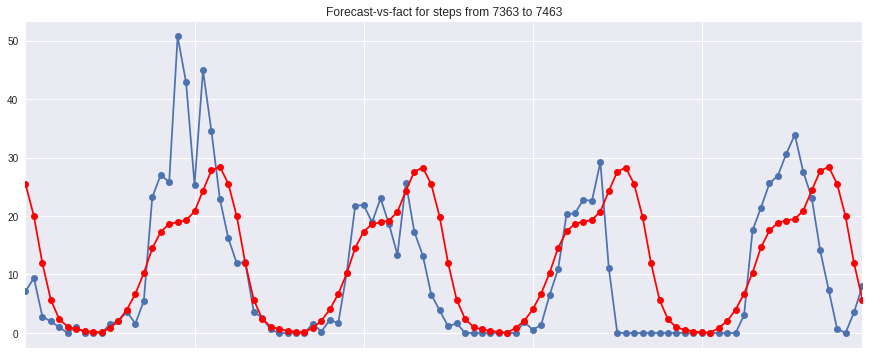

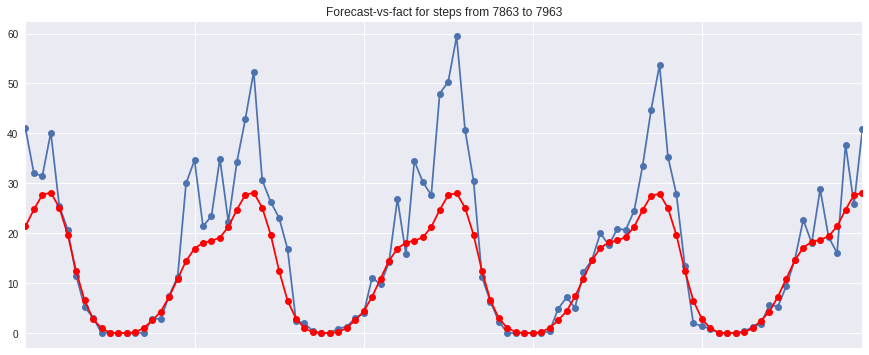

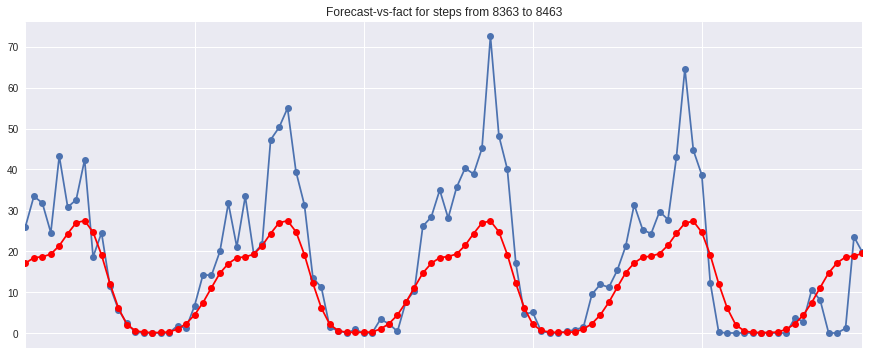

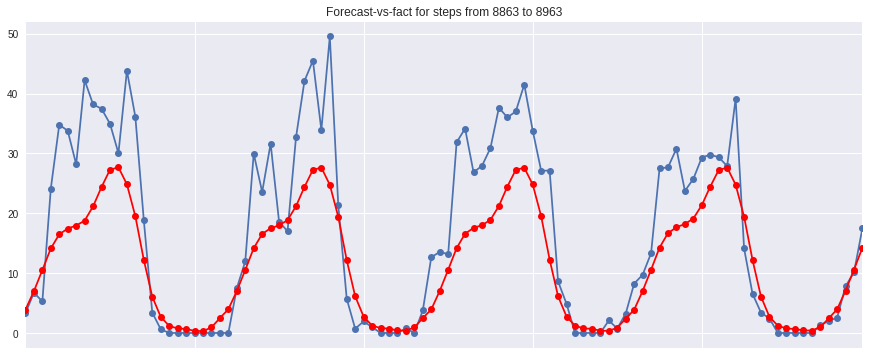

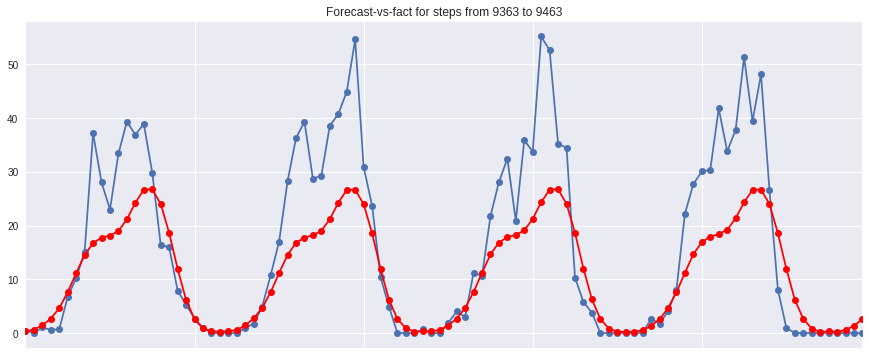

In [16]:
lstm_runner = RunnerOfLSTM(horizon, n_lags, rnn_width, rnn_depth)
# Training on `ser[:train_test_frontier + horizon]` involves test data.
score = lstm_runner.run(ser[:train_test_frontier],
                        ser[train_test_frontier - n_lags:],  # To have lag features.
                        batch_size, n_epochs, learn_rate, keep_prob,
                        ckpt_path='./trained_models/lstm.ckpt')
score

Results are quite decent — $R^2$ is about two-thirds. Graphs evidence that LSTM has successfully learnt intraday seasonality pattern.

# Forecasting with MLP

### Functions and classes

In [17]:
def build_mlp(inputs, n_outputs, hidden_layers_widths, keep_prob):
    """
    Defines architecture of an MLP.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type hidden_layers_widths: list(int)
    @type keep_prob: tensorflow.Tensor
    @rtype: tensorflow.Tensor
    """
    curr_layer = inputs
    for i in range(len(hidden_layers_widths)):
        curr_layer = tf.contrib.layers.fully_connected(curr_layer,
                                                       hidden_layers_widths[i],
                                                       activation_fn=None)
        curr_layer = tf.layers.dropout(curr_layer, keep_prob)
    preds = tf.contrib.layers.fully_connected(curr_layer,
                                              n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds

In [18]:
def get_batches_for_mlp(ser, batch_size, horizon, n_lags):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @rtype: list(tuple(numpy.ndarray))
    """
    # TODO: Engineer features described in the problem setup.
    df = take_ahead_and_lagged_values(ser, horizon, n_lags)
    
    # Trim some old observations if they do not fit to `batch_size`.
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[-(n_batches*batch_size + horizon):-horizon, :]
    
    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, horizon))
    return list(zip(x_array, y_array))

In [19]:
class RunnerOfMLP(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate MLP performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values,
    a current value, and some aggregates
    as features.
    """

    def __init__(self, horizon, n_lags, hidden_layers_widths):
        """
        @type horizon: int
        @type n_lags: int
        @type hidden_layers_widths: int
        """
        super().__init__(horizon, n_lags)
        self.hidden_layers_widths = hidden_layers_widths
        
        with self.graph.as_default():
            self.preds = build_mlp(self.inputs, self.horizon,
                                   self.hidden_layers_widths, self.keep_prob)
        self._set_optimization_problem()

    def _define_placeholders(self):
        """
        Defines placeholders for input values,
        target values, learning rate, and
        probability to keep unit after dropout.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        Trains MLP and informs about training.
        Also can save trained model
        if `ckpt_path` is set.

        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_mlp(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.learning_rate: learn_rate,
                             self.keep_prob: keep_prob}
                y_hat, train_loss, _ = self.sess.run([self.preds,
                                                      self.cost,
                                                      self.train_optim],
                                                     feed_dict)
            if epoch_cnt % 5 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        if ckpt_path is not None:
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.

        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batches = get_batches_for_mlp(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            feed_dict = {self.inputs: x,
                         self.keep_prob: 1}
            y_hat = self.sess.run(self.preds, feed_dict)
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0], y_hat[0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0], y_hat[0], batch_cnt)

        return sum(scores) / len(scores)

### Application

In [20]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
hidden_layers_widths = [10]

# Hyperparameters of training.
batch_size = 32
n_epochs = 20
learn_rate = 0.001
keep_prob = 0.8

Epoch   0:    train_loss = 275.899
Epoch   5:    train_loss = 270.308
Epoch  10:    train_loss = 273.865
Epoch  15:    train_loss = 277.736


0.7284349273619547

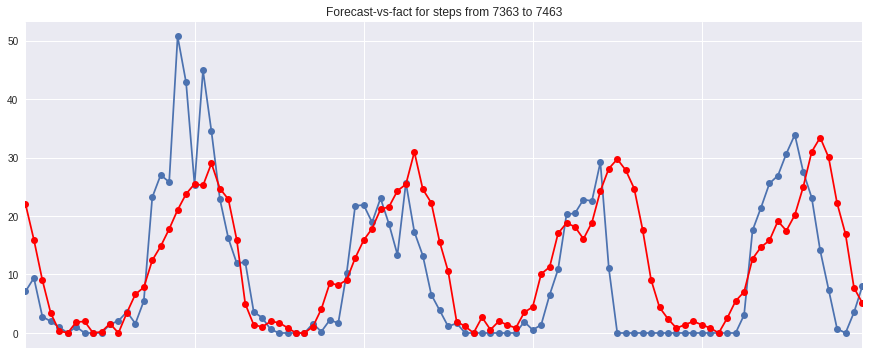

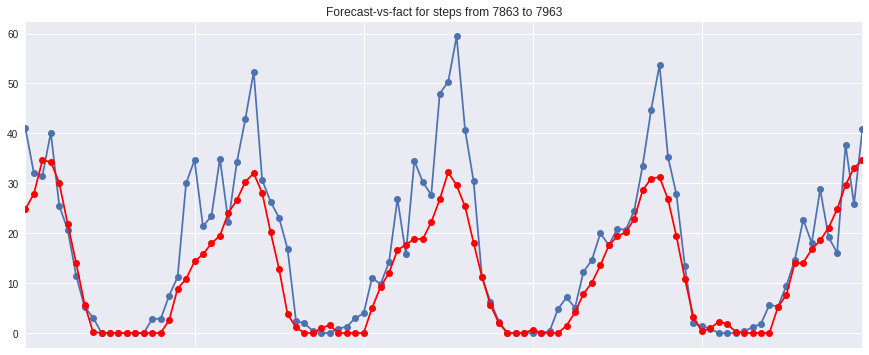

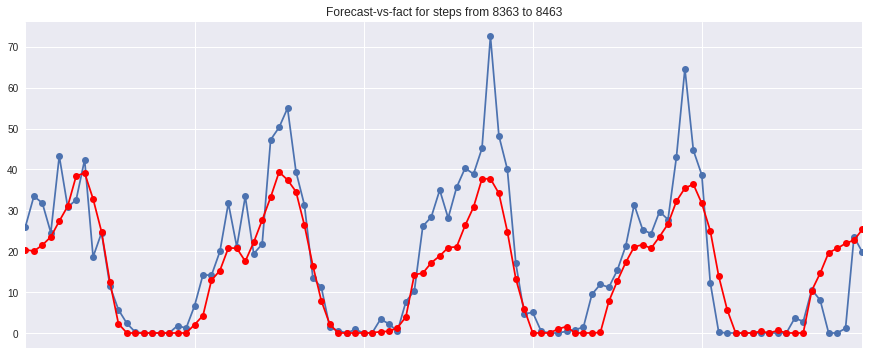

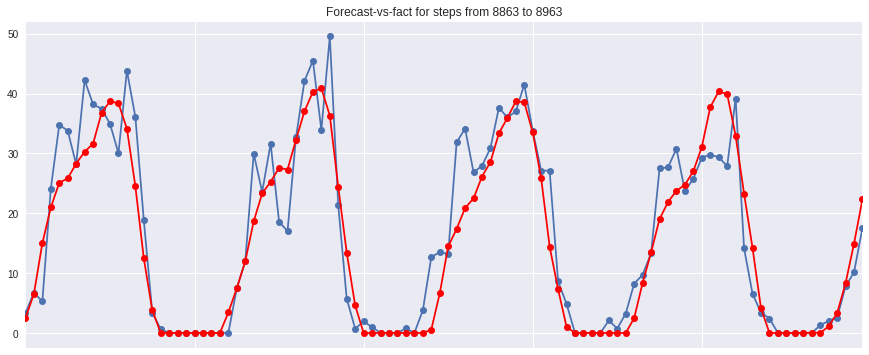

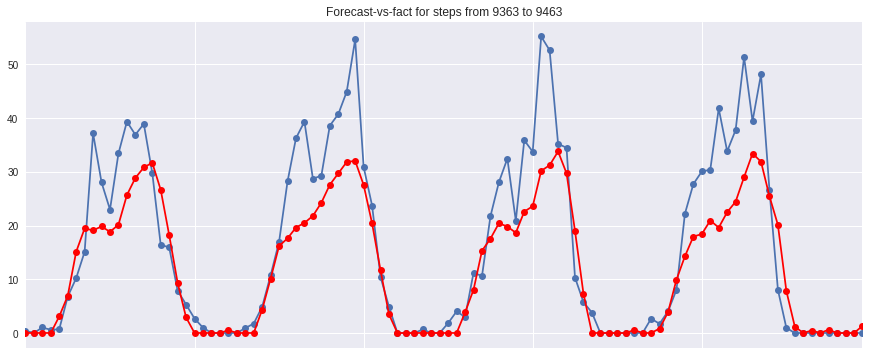

In [21]:
mlp_runner = RunnerOfMLP(horizon, n_lags, hidden_layers_widths)
score = mlp_runner.run(ser[:train_test_frontier],  # Not `ser[:train_test_frontier + horizon]`.
                       ser[train_test_frontier - n_lags:],  # To have lag features.
                       batch_size, n_epochs, learn_rate, keep_prob,
                       ckpt_path='./trained_models/mlp.ckpt')
score

The score is significantly higher than that of LSTM and training goes much faster.

# Conclusion

To be continued.